---
title: "Gradient Boosting with Polynomial Decision Trees"
---

Fit an arbitrarily complex Polynomial in Decision Tree leaf nodes, rather than a flat line. Code for `polynomial_boosting` can be found [here](https://github.com/SaremS/polynomial_boosting).

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from polynomial_boosting import PolynomialBoostingModel

import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

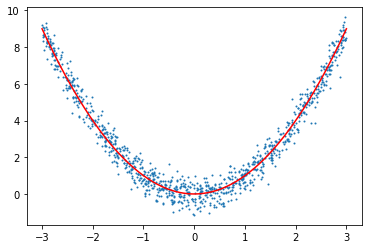

In [2]:
np.random.seed(123)

def f(X):
    return  X**2

N = 1000

X = np.random.uniform(size=(N,1)) * 6 - 3

#model requires that `y` is a matrix and not a vector (contrary to sklearn models)
y = f(X) + np.random.normal(size=(N,1)) * 0.5  

line = np.linspace(-3,3,250)

plt.scatter(X[:,0],y[:,0],s=1)
plt.plot(line,f(line),c="red")

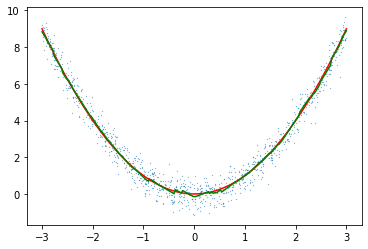

In [3]:
model = PolynomialBoostingModel(1,     #polynomial_level
                                0.25, #learning rate
                                5.0,  #regression regularization
                                100,  #n_trees
                                10,   #min_samples_leaf
                                1.0,  #goss alpha
                                0.0,  #goss beta
                                1)    #random seed

model.fit_fast(X,y)

preds = model.predict_fast(line.reshape(-1,1)).reshape(-1)

plt.scatter(X[:,0],y[:,0],s=0.05)
plt.plot(line,f(line),c="red")
plt.plot(line,preds,c="green")

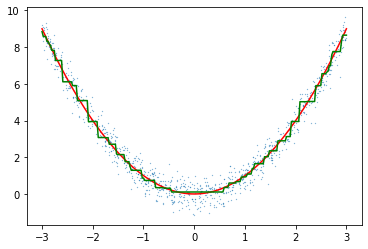

In [4]:
model2 = GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate = 0.25)
model2.fit(X,y.reshape(-1))

preds2 = model2.predict(line.reshape(-1,1)).reshape(-1)

plt.scatter(X[:,0],y[:,0],s=0.05)
plt.plot(line,f(line),c="red")
plt.plot(line,preds2,c="green")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


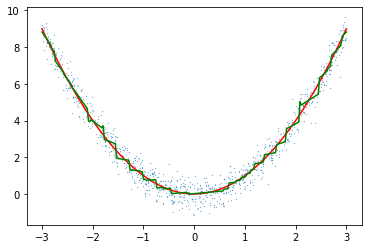

In [5]:
lgb_dataset = lgb.Dataset(X, label=y.reshape(-1), params={'linear_tree': True})

lgb_params = {
    "objective": "regression",
    "metric": "l2",
    "num_iterations": 100,
    "num_leaves": 2,
    "learning_rate": 0.25,
    "linear_lambda": 5.0,
    "min_data_in_leaf": 10,
    "verbosity": -1
}

model3 = lgb.train(lgb_params, lgb_dataset)

preds3 = model3.predict(line.reshape(-1,1)).reshape(-1)

plt.scatter(X[:,0],y[:,0],s=0.05)
plt.plot(line,f(line),c="red")
plt.plot(line,preds3,c="green")

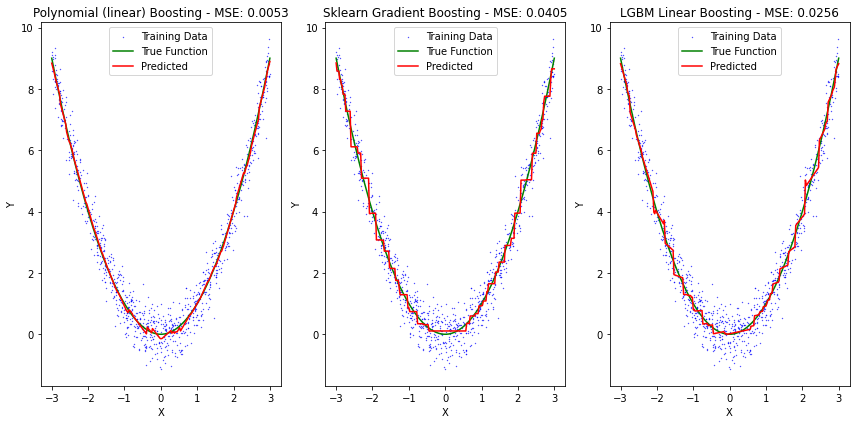

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

axes[0].scatter(X[:,0], y[:,0], color='blue', label='Training Data', s=0.1)
axes[0].plot(line, f(line), color='green', label='True Function')
axes[0].plot(line, preds, color='red', label='Predicted')
axes[0].set_title('Polynomial (linear) Boosting - MSE: {:.4f}'.format(np.mean((preds-f(line))**2)))
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].legend()

axes[1].scatter(X[:,0], y[:,0], color='blue', label='Training Data', s=0.1)
axes[1].plot(line, f(line), color='green', label='True Function')
axes[1].plot(line, preds2, color='red', label='Predicted')
axes[1].set_title('Sklearn Gradient Boosting - MSE: {:.4f}'.format(np.mean((preds2-f(line))**2)))
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].legend()

axes[2].scatter(X[:,0], y[:,0], color='blue', label='Training Data', s=0.1)
axes[2].plot(line, f(line), color='green', label='True Function')
axes[2].plot(line, preds3, color='red', label='Predicted')
axes[2].set_title('LGBM Linear Boosting - MSE: {:.4f}'.format(np.mean((preds3-f(line))**2)))
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
axes[2].legend()

plt.tight_layout()

In [7]:
Xd, yd = fetch_california_housing(return_X_y=True)

#small train set, as the model is still quite slow
X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.975, random_state=123)


Xm = np.mean(X_train,0).reshape(1,-1)
Xs = np.std(X_train,0).reshape(1,-1)

ym = np.mean(y_train)
ys = np.std(y_train)

X_train = (X_train - Xm) / Xs
y_train = (y_train - ym) / ys

X_test = (X_test - Xm) / Xs

In [8]:
d_model = PolynomialBoostingModel(1,    #polynomial level
                                  0.25, #learning rate
                                  5.0,  #regression regularization
                                  100,  #n_trees
                                  10,   #min_samples_leaf
                                  1.0,  #goss alpha
                                  0.0,  #goss beta
                                  1)    #random seed
d_model.fit_fast(X_train,y_train.reshape(-1,1))

d_preds = d_model.predict_fast(X_test).reshape(-1) * ys + ym

In [9]:
d_model2 = GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate = 0.25)
d_model2.fit(X_train,y_train)

d_preds2 = d_model2.predict(X_test) * ys + ym

In [10]:
lgb_dataset = lgb.Dataset(X_train, label=y_train.reshape(-1), params={'linear_tree': True})

lgb_params = {
    "objective": "regression",
    "metric": "l2",
    "num_iterations": 100,
    "num_leaves": 2,
    "learning_rate": 0.25,
    "linear_lambda": 5.0,
    "min_data_in_leaf": 10,
    "verbosity": -1
}

d_model3 = lgb.train(lgb_params, lgb_dataset)

d_preds3 = d_model3.predict(X_test).reshape(-1) * ys + ym

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [11]:
np.mean((d_preds-y_test)**2)

0.40638200743172254

In [12]:
np.mean((d_preds2-y_test)**2)

0.4231840786265534

In [13]:
np.mean((d_preds3-y_test)**2) 

0.41076314048606744

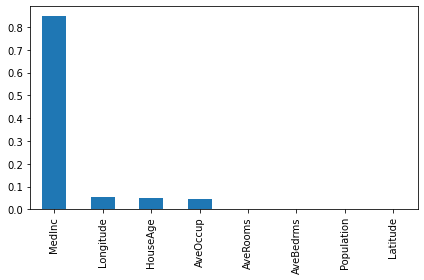

In [14]:
feature_names = fetch_california_housing()["feature_names"]
importances = pd.Series(d_model.get_feature_importances()[:8], index = feature_names)

importances.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

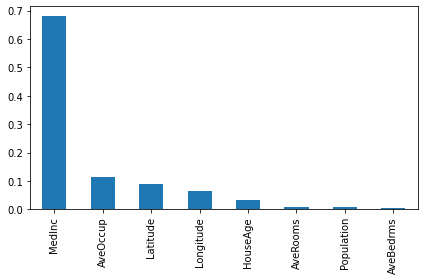

In [15]:
importances2 = pd.Series(d_model2.feature_importances_, index = feature_names)

importances2.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

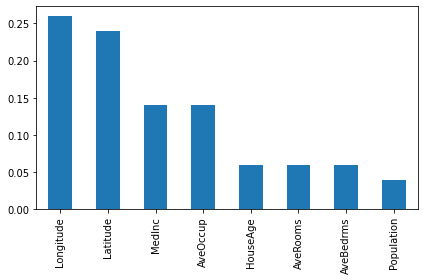

In [16]:
importances3 = pd.Series(d_model3.feature_importance()/np.sum(d_model3.feature_importance()), index=feature_names)

importances3.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

# Larger dataset

In [17]:
Xd, yd = fetch_california_housing(return_X_y=True)

#small train set, as the model is still quite slow
X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.2, random_state=123)


Xm = np.mean(X_train,0).reshape(1,-1)
Xs = np.std(X_train,0).reshape(1,-1)

ym = np.mean(y_train)
ys = np.std(y_train)

X_train = (X_train - Xm) / Xs
y_train = (y_train - ym) / ys

X_test = (X_test - Xm) / Xs

Use GOSS sampling to keep computational demand feasible
(see [the LightGBM paper, algorithm 2](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf))

Currently, not using specific weights for the randomly sampled subset in GOSS appears to outperform the exact GOSS proposal. This might be due to the regression models 
not being fit with those weights as well but only the total node losses.

In [18]:
d_model = PolynomialBoostingModel(
                                1, #polynomial level
                                0.25, #learning rate
                                5.0,  #regression regularization
                                100,  #n_trees
                                10,   #min_samples_leaf
                                0.2,  #goss alpha
                                0.025,  #goss beta
                                1)    #random seed
d_model.fit_fast(X_train,y_train.reshape(-1,1))

d_preds = d_model.predict_fast(X_test).reshape(-1) * ys + ym

In [19]:
d_model2 = GradientBoostingRegressor(max_depth=1, n_estimators=100, learning_rate = 0.25, min_samples_leaf=10)
d_model2.fit(X_train,y_train)

d_preds2 = d_model2.predict(X_test) * ys + ym

In [20]:
lgb_dataset = lgb.Dataset(X_train, label=y_train.reshape(-1), params={'linear_tree': True})

lgb_params = {
    "objective": "regression",
    "metric": "l2",
    "num_iterations": 100,
    "num_leaves": 2,
    "learning_rate": 0.25,
    "linear_lambda": 5.0,
    "data_sampling_strategy": "goss",
    "top_rate": 0.2, #=goss alpha
    "other_rate": 0.025, #=goss beta
    "verbosity": -1
}

d_model3 = lgb.train(lgb_params, lgb_dataset)

d_preds3 = d_model3.predict(X_test).reshape(-1) * ys + ym

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [21]:
d_model4 = PolynomialBoostingModel(
                                2, #polynomial level
                                0.25, #learning rate
                                5.0,  #regression regularization
                                100,  #n_trees
                                10,   #min_samples_leaf
                                0.2,  #goss alpha
                                0.025,  #goss beta
                                1)    #random seed
d_model4.fit_fast(X_train,y_train.reshape(-1,1))

d_preds4 = d_model4.predict_fast(X_test).reshape(-1) * ys + ym

In [22]:
np.mean((d_preds-y_test)**2) #boosted linear trees (p=1)

0.34790501763806014

In [23]:
np.mean((d_preds2-y_test)**2) #sklearn boosted trees (p=0)

0.3797511677878719

In [24]:
np.mean((d_preds3-y_test)**2) #lgbm boosted trees (p=1)

0.3640894459649956

In [25]:
np.mean((d_preds4-y_test)**2) #boosted quadratic trees (p=2)

0.33865369672689777

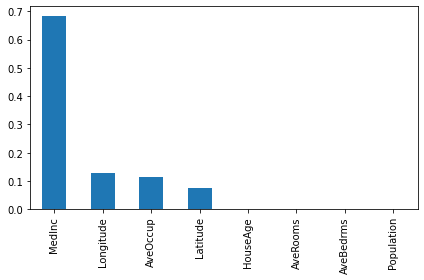

In [26]:
feature_names = fetch_california_housing()["feature_names"]
importances = pd.Series(d_model.get_feature_importances()[:8], index = feature_names)

importances.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

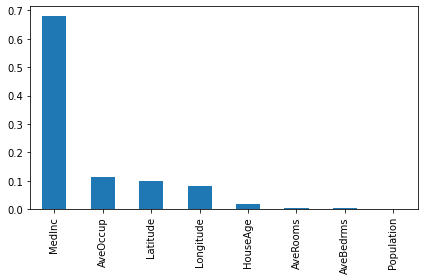

In [27]:
importances2 = pd.Series(d_model2.feature_importances_, index = feature_names)

importances2.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

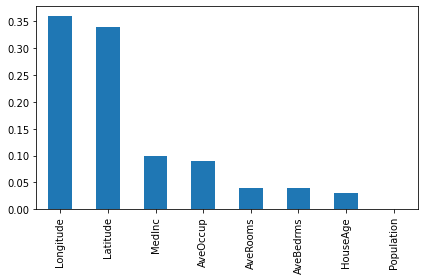

In [28]:
importances3 = pd.Series(d_model3.feature_importance()/np.sum(d_model3.feature_importance()), index=feature_names)

importances3.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()

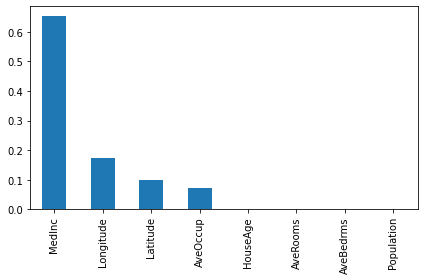

In [29]:
importances4 = pd.Series(d_model4.get_feature_importances()[:8], index = feature_names)

importances4.sort_values(ascending=False).plot(kind="bar")
plt.tight_layout()